# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

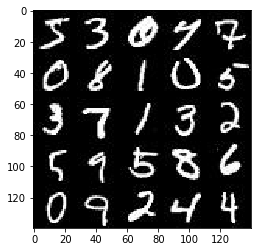

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

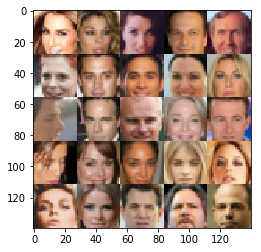

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\egork\\Anaconda3\\envs\\aind\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\egork\\Anaconda3\\envs\\aind\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\egork\\Anaconda3\\envs\\aind\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\egork\\Anaconda3\\envs\\aind\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\egork\\Anaconda3\\envs\\aind\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "C:\\Users\\eg

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [21]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    x = images
    with tf.variable_scope('discriminator', reuse=reuse):
        filters = 64
        # Input layer is 28x28x3
        x = tf.layers.conv2d(inputs = x, 
                     filters = filters, 
                     kernel_size = 5, 
                     strides = 1,
                     padding="same")
        x = tf.concat([images,tf.contrib.keras.layers.LeakyReLU(alpha)(x)],3)
        for i in range(3):
            x = tf.layers.conv2d(inputs = x, 
                                 filters = filters, 
                                 kernel_size = 5, 
                                 strides = 2,
                                 padding="same")
            #x = tf.layers.batch_normalization(x, training = True)
            x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
            filters = 2*filters
        #print(x.get_shape().as_list())
        flat = tf.contrib.layers.flatten(x)
        logits = tf.layers.dense(flat,1)
        #out = tf.sigmoid(logits)
        
        return logits

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    # Why on earth does the test check for the number of args?
    alpha = 0.2
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    init_dim =[-1,7,7,512]
    init_len = 7*7*512
    filters = 512
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x = tf.layers.dense(z,init_len)
        x = tf.reshape(x, tf.cast(init_dim, tf.int32))
        x = tf.layers.batch_normalization(x, training = is_train)
        x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
        # so now we're at 7x7x512
        for i in range(2):
            filters = filters/2
            x = tf.layers.conv2d_transpose(inputs = x, 
                                           filters = int(filters), 
                                           kernel_size =5,
                                           strides = 2,
                                           padding = 'same')

            x = tf.layers.batch_normalization(x, training = is_train)
            x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
        
        x = tf.layers.conv2d_transpose(inputs = x, 
                                   filters = out_channel_dim, 
                                   kernel_size = 5,
                                   strides = 1,
                                   padding = 'same')
        # Output layer, 28x28x3 
        # rather than mess around with convolutions to get the size just right, let's just trim it
        #logits = tf.slice(x, [0,0,0,0],[-1,28,28,-1])
        logits = x
        out = 0.5*tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim, batch_size, alpha=0.2, lmbda = 10):
    
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    input_fake = generator(input_z, out_channel_dim)
    d_real = discriminator(input_real, alpha=alpha)
    d_fake = discriminator(input_fake, reuse=True, alpha=alpha)
    
    alpha2 = tf.random_uniform(shape=[batch_size,1,1,1], minval=0.,maxval=1.)
    
    #TODO: does this work correctly with broadcasting?
    interpolates = alpha2*input_real + ((1-alpha2)*input_fake)
    disc_interpolates = discriminator(interpolates, reuse=True, alpha=alpha)
    gradients = tf.gradients([disc_interpolates], [interpolates])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1,2,3]))
    gradient_penalty = tf.reduce_mean((slopes-1)**2)
 
    
    
    d_loss = -(tf.reduce_mean(d_real) - tf.reduce_mean(d_fake))
    d_loss += lmbda*gradient_penalty
    
    g_loss = -tf.reduce_mean(d_fake)

    return d_loss, g_loss


# """
# DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
# """
# tests.test_model_loss(model_loss)

### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, beta2=0.9).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, beta2=0.9).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    critic_iter= 5
    
    dummy, image_width, image_height, out_channel_dim =  data_shape
    input_real, input_z, learning_rate_ph = model_inputs(image_width, image_height, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim, batch_size)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
                
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                for _ in range(critic_iter):
                    _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1,epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z,out_channel_dim, is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess,9, input_z, out_channel_dim, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
    import pickle
    with open('samples.pkl', 'wb') as f:
        pickle.dump(samples, f)
    
    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: -11.4020... Generator Loss: 2.6068
Epoch 1/2... Discriminator Loss: -12.9831... Generator Loss: 7.2360
Epoch 1/2... Discriminator Loss: -10.1135... Generator Loss: 4.4363
Epoch 1/2... Discriminator Loss: -9.9357... Generator Loss: 4.2722
Epoch 1/2... Discriminator Loss: -6.3555... Generator Loss: -0.2616
Epoch 1/2... Discriminator Loss: -1.3307... Generator Loss: -6.0674
Epoch 1/2... Discriminator Loss: -1.4566... Generator Loss: -2.9073
Epoch 1/2... Discriminator Loss: -1.1830... Generator Loss: 0.2199
Epoch 1/2... Discriminator Loss: -1.4928... Generator Loss: 1.2746
Epoch 1/2... Discriminator Loss: -1.3211... Generator Loss: 5.2268


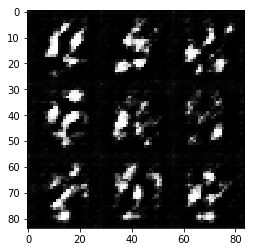

Epoch 1/2... Discriminator Loss: -1.9404... Generator Loss: 10.0477
Epoch 1/2... Discriminator Loss: -1.7908... Generator Loss: 6.5816
Epoch 1/2... Discriminator Loss: -1.5782... Generator Loss: 5.6743
Epoch 1/2... Discriminator Loss: -1.3588... Generator Loss: 5.6463
Epoch 1/2... Discriminator Loss: -2.1511... Generator Loss: 9.9348
Epoch 1/2... Discriminator Loss: -1.6675... Generator Loss: 7.7801
Epoch 1/2... Discriminator Loss: -2.0240... Generator Loss: 5.4274
Epoch 1/2... Discriminator Loss: -1.4978... Generator Loss: 8.0349
Epoch 1/2... Discriminator Loss: -1.7279... Generator Loss: 8.4025
Epoch 1/2... Discriminator Loss: -2.0055... Generator Loss: 8.7321


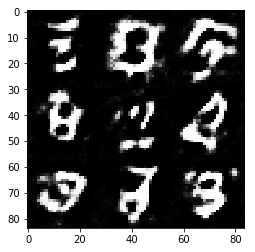

Epoch 1/2... Discriminator Loss: -2.8165... Generator Loss: 7.5057
Epoch 1/2... Discriminator Loss: -2.1443... Generator Loss: 7.3857
Epoch 1/2... Discriminator Loss: -1.7801... Generator Loss: 5.0924
Epoch 1/2... Discriminator Loss: -2.0377... Generator Loss: 3.7839
Epoch 1/2... Discriminator Loss: -1.8819... Generator Loss: 5.3636
Epoch 1/2... Discriminator Loss: -1.8522... Generator Loss: 2.1230
Epoch 1/2... Discriminator Loss: -1.5515... Generator Loss: 0.6416
Epoch 1/2... Discriminator Loss: -1.4878... Generator Loss: 4.3918
Epoch 1/2... Discriminator Loss: -1.3818... Generator Loss: 6.2459
Epoch 1/2... Discriminator Loss: -1.8623... Generator Loss: 2.8725


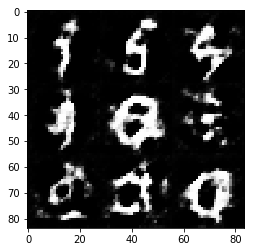

Epoch 1/2... Discriminator Loss: -1.9492... Generator Loss: 2.7451
Epoch 1/2... Discriminator Loss: -1.6333... Generator Loss: 2.2220
Epoch 1/2... Discriminator Loss: -2.1619... Generator Loss: 3.3841
Epoch 1/2... Discriminator Loss: -1.9744... Generator Loss: -0.2320
Epoch 1/2... Discriminator Loss: -1.9348... Generator Loss: 1.2971
Epoch 1/2... Discriminator Loss: -1.5475... Generator Loss: -0.7781
Epoch 1/2... Discriminator Loss: -1.4706... Generator Loss: -2.6111
Epoch 1/2... Discriminator Loss: -1.8538... Generator Loss: 2.3499
Epoch 1/2... Discriminator Loss: -1.3575... Generator Loss: -0.7538
Epoch 1/2... Discriminator Loss: -0.9277... Generator Loss: -2.0281


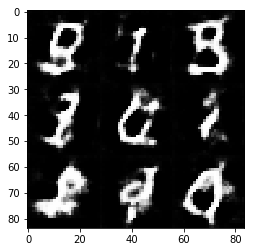

Epoch 1/2... Discriminator Loss: -1.5997... Generator Loss: 2.5943
Epoch 1/2... Discriminator Loss: -1.2276... Generator Loss: 6.0484
Epoch 1/2... Discriminator Loss: -1.5051... Generator Loss: -2.3049
Epoch 1/2... Discriminator Loss: -1.0914... Generator Loss: 3.3017
Epoch 1/2... Discriminator Loss: -1.9041... Generator Loss: -1.2855
Epoch 1/2... Discriminator Loss: -1.2116... Generator Loss: -5.0652
Epoch 1/2... Discriminator Loss: -1.4117... Generator Loss: -2.8696
Epoch 1/2... Discriminator Loss: -1.9085... Generator Loss: 5.5805
Epoch 1/2... Discriminator Loss: -1.4310... Generator Loss: 0.3443
Epoch 1/2... Discriminator Loss: -1.3619... Generator Loss: -5.0271


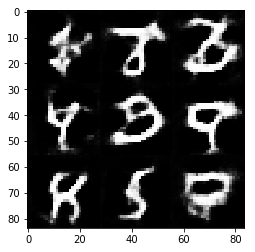

Epoch 1/2... Discriminator Loss: -1.4486... Generator Loss: -5.8828
Epoch 1/2... Discriminator Loss: -1.0545... Generator Loss: -0.6818
Epoch 1/2... Discriminator Loss: -1.3743... Generator Loss: -1.4773
Epoch 1/2... Discriminator Loss: -1.6098... Generator Loss: -3.2145
Epoch 1/2... Discriminator Loss: -0.9404... Generator Loss: -4.9921
Epoch 1/2... Discriminator Loss: -1.1521... Generator Loss: -3.2052
Epoch 1/2... Discriminator Loss: -0.9601... Generator Loss: -8.6231
Epoch 1/2... Discriminator Loss: -1.1061... Generator Loss: -2.2711
Epoch 1/2... Discriminator Loss: -1.0361... Generator Loss: 0.5309
Epoch 1/2... Discriminator Loss: -1.6609... Generator Loss: 1.6159


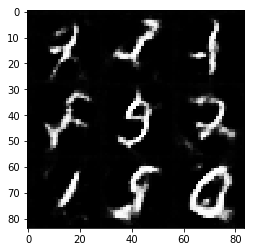

Epoch 1/2... Discriminator Loss: -1.3537... Generator Loss: -0.9815
Epoch 1/2... Discriminator Loss: -1.2416... Generator Loss: -4.5052
Epoch 1/2... Discriminator Loss: -1.2965... Generator Loss: -1.2846
Epoch 1/2... Discriminator Loss: -0.7738... Generator Loss: -5.2260
Epoch 1/2... Discriminator Loss: -1.2622... Generator Loss: -1.0506
Epoch 1/2... Discriminator Loss: -1.0774... Generator Loss: -7.2731
Epoch 1/2... Discriminator Loss: -0.9266... Generator Loss: -1.0801
Epoch 1/2... Discriminator Loss: -1.3274... Generator Loss: 3.0106
Epoch 1/2... Discriminator Loss: -1.3383... Generator Loss: -5.0846
Epoch 1/2... Discriminator Loss: -0.7153... Generator Loss: -7.8561


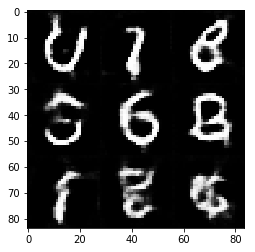

Epoch 1/2... Discriminator Loss: -1.9094... Generator Loss: -8.8946
Epoch 1/2... Discriminator Loss: -0.7912... Generator Loss: 3.1788
Epoch 1/2... Discriminator Loss: -0.9627... Generator Loss: -0.6860
Epoch 1/2... Discriminator Loss: -1.4085... Generator Loss: -2.1695
Epoch 1/2... Discriminator Loss: -1.2925... Generator Loss: -5.4504
Epoch 1/2... Discriminator Loss: -1.6138... Generator Loss: -1.4790
Epoch 1/2... Discriminator Loss: -1.5972... Generator Loss: -3.9229
Epoch 1/2... Discriminator Loss: -2.0309... Generator Loss: -5.9155
Epoch 1/2... Discriminator Loss: -1.0812... Generator Loss: 0.3713
Epoch 1/2... Discriminator Loss: -1.1353... Generator Loss: -1.6828


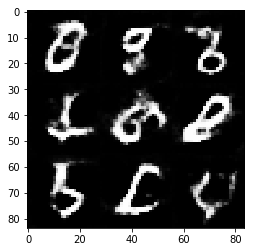

Epoch 1/2... Discriminator Loss: -1.0563... Generator Loss: -2.0647
Epoch 1/2... Discriminator Loss: -1.5628... Generator Loss: 0.0785
Epoch 1/2... Discriminator Loss: -0.9470... Generator Loss: -0.5564
Epoch 1/2... Discriminator Loss: -2.4118... Generator Loss: -6.5728
Epoch 1/2... Discriminator Loss: -1.3205... Generator Loss: 3.0602
Epoch 1/2... Discriminator Loss: -1.0468... Generator Loss: 2.6236
Epoch 1/2... Discriminator Loss: -1.1320... Generator Loss: -0.0601
Epoch 1/2... Discriminator Loss: -1.4159... Generator Loss: -1.4599
Epoch 1/2... Discriminator Loss: -1.3462... Generator Loss: -6.5936
Epoch 1/2... Discriminator Loss: -2.0511... Generator Loss: -5.8394


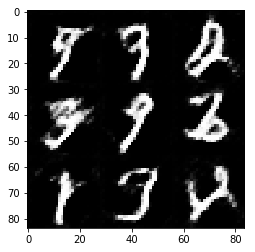

Epoch 1/2... Discriminator Loss: -1.2502... Generator Loss: -5.9246
Epoch 1/2... Discriminator Loss: -0.9544... Generator Loss: -3.6946
Epoch 1/2... Discriminator Loss: -1.2185... Generator Loss: -4.1511
Epoch 2/2... Discriminator Loss: -1.7139... Generator Loss: -9.0087
Epoch 2/2... Discriminator Loss: -0.9275... Generator Loss: -2.7131
Epoch 2/2... Discriminator Loss: -1.0387... Generator Loss: -3.2640
Epoch 2/2... Discriminator Loss: -1.1270... Generator Loss: -3.5864
Epoch 2/2... Discriminator Loss: -1.0690... Generator Loss: -1.2969
Epoch 2/2... Discriminator Loss: -1.1689... Generator Loss: -3.9607
Epoch 2/2... Discriminator Loss: -1.7485... Generator Loss: -2.0996


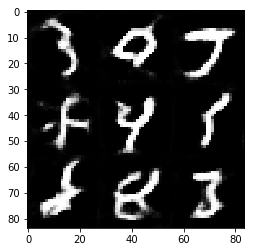

Epoch 2/2... Discriminator Loss: -2.1902... Generator Loss: 0.8003
Epoch 2/2... Discriminator Loss: -2.0826... Generator Loss: 0.3957
Epoch 2/2... Discriminator Loss: -1.4019... Generator Loss: -4.3771
Epoch 2/2... Discriminator Loss: -1.2078... Generator Loss: -4.1012
Epoch 2/2... Discriminator Loss: -1.1195... Generator Loss: -0.6131
Epoch 2/2... Discriminator Loss: -1.4031... Generator Loss: -3.3273
Epoch 2/2... Discriminator Loss: -1.0890... Generator Loss: -0.0941
Epoch 2/2... Discriminator Loss: -1.1894... Generator Loss: -3.9054
Epoch 2/2... Discriminator Loss: -0.8076... Generator Loss: 0.6856
Epoch 2/2... Discriminator Loss: -1.0048... Generator Loss: 0.7670


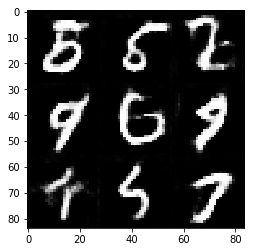

Epoch 2/2... Discriminator Loss: -2.5669... Generator Loss: 1.4555
Epoch 2/2... Discriminator Loss: -1.7169... Generator Loss: -4.4201
Epoch 2/2... Discriminator Loss: -1.4143... Generator Loss: -3.6251
Epoch 2/2... Discriminator Loss: -1.5222... Generator Loss: -8.1661
Epoch 2/2... Discriminator Loss: -0.3913... Generator Loss: -2.1381
Epoch 2/2... Discriminator Loss: -1.0653... Generator Loss: -3.6555
Epoch 2/2... Discriminator Loss: -1.5196... Generator Loss: 2.3810
Epoch 2/2... Discriminator Loss: -0.9306... Generator Loss: -2.2781
Epoch 2/2... Discriminator Loss: -1.0714... Generator Loss: 2.3157
Epoch 2/2... Discriminator Loss: -0.9731... Generator Loss: -0.3537


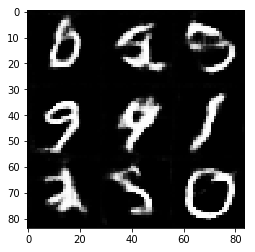

Epoch 2/2... Discriminator Loss: -1.6221... Generator Loss: -3.0107
Epoch 2/2... Discriminator Loss: -1.3813... Generator Loss: -7.2120
Epoch 2/2... Discriminator Loss: -1.5377... Generator Loss: -1.4378
Epoch 2/2... Discriminator Loss: -1.7067... Generator Loss: 2.2775
Epoch 2/2... Discriminator Loss: -1.1621... Generator Loss: -5.2877
Epoch 2/2... Discriminator Loss: -1.2483... Generator Loss: -4.3878
Epoch 2/2... Discriminator Loss: -1.0287... Generator Loss: -3.9137
Epoch 2/2... Discriminator Loss: -1.0185... Generator Loss: -5.3847
Epoch 2/2... Discriminator Loss: -2.0711... Generator Loss: 1.6292
Epoch 2/2... Discriminator Loss: -1.2891... Generator Loss: -3.6864


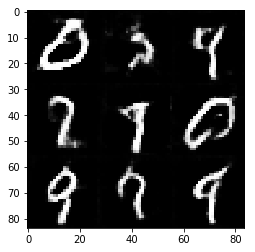

Epoch 2/2... Discriminator Loss: -0.9689... Generator Loss: -1.5132
Epoch 2/2... Discriminator Loss: -0.7418... Generator Loss: -2.4290
Epoch 2/2... Discriminator Loss: -1.6616... Generator Loss: -1.5991
Epoch 2/2... Discriminator Loss: -1.7011... Generator Loss: -5.8895
Epoch 2/2... Discriminator Loss: -1.3505... Generator Loss: -1.8693
Epoch 2/2... Discriminator Loss: -1.7465... Generator Loss: 1.2056
Epoch 2/2... Discriminator Loss: -1.5770... Generator Loss: -2.5598
Epoch 2/2... Discriminator Loss: -1.2433... Generator Loss: 2.1315
Epoch 2/2... Discriminator Loss: -1.2156... Generator Loss: -3.7314
Epoch 2/2... Discriminator Loss: -1.8022... Generator Loss: -4.5256


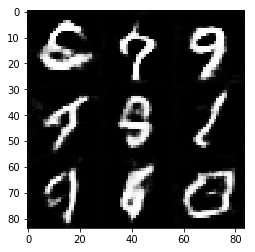

Epoch 2/2... Discriminator Loss: -1.5561... Generator Loss: -3.9433
Epoch 2/2... Discriminator Loss: -1.3358... Generator Loss: 0.4690
Epoch 2/2... Discriminator Loss: -1.2396... Generator Loss: -4.0499
Epoch 2/2... Discriminator Loss: -1.6491... Generator Loss: -0.6948
Epoch 2/2... Discriminator Loss: -1.6501... Generator Loss: -4.2054
Epoch 2/2... Discriminator Loss: -1.2688... Generator Loss: -0.7182
Epoch 2/2... Discriminator Loss: -1.1182... Generator Loss: -0.7782
Epoch 2/2... Discriminator Loss: -1.3612... Generator Loss: -1.5820
Epoch 2/2... Discriminator Loss: -1.1523... Generator Loss: -3.1604
Epoch 2/2... Discriminator Loss: -2.2296... Generator Loss: 1.3623


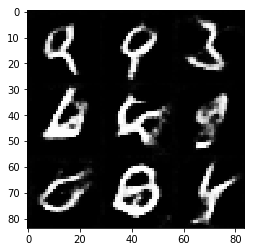

Epoch 2/2... Discriminator Loss: -1.8346... Generator Loss: -0.2986
Epoch 2/2... Discriminator Loss: -1.3055... Generator Loss: 2.6277
Epoch 2/2... Discriminator Loss: -1.6883... Generator Loss: 2.6221
Epoch 2/2... Discriminator Loss: -1.7824... Generator Loss: 0.7004
Epoch 2/2... Discriminator Loss: -1.9989... Generator Loss: 1.5650
Epoch 2/2... Discriminator Loss: -1.4599... Generator Loss: -3.4711
Epoch 2/2... Discriminator Loss: -1.2046... Generator Loss: 2.4392
Epoch 2/2... Discriminator Loss: -1.1092... Generator Loss: -2.3612
Epoch 2/2... Discriminator Loss: -1.2359... Generator Loss: 1.8783
Epoch 2/2... Discriminator Loss: -1.4198... Generator Loss: -1.5072


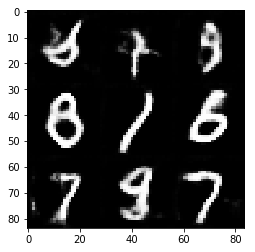

Epoch 2/2... Discriminator Loss: -0.9968... Generator Loss: -0.6497
Epoch 2/2... Discriminator Loss: -1.7213... Generator Loss: 1.9546
Epoch 2/2... Discriminator Loss: -2.1061... Generator Loss: 0.1186
Epoch 2/2... Discriminator Loss: -1.3058... Generator Loss: -0.9948
Epoch 2/2... Discriminator Loss: -1.4540... Generator Loss: -2.5895
Epoch 2/2... Discriminator Loss: -1.9234... Generator Loss: 4.1693
Epoch 2/2... Discriminator Loss: -1.2972... Generator Loss: -4.2592
Epoch 2/2... Discriminator Loss: -1.5338... Generator Loss: -3.7404
Epoch 2/2... Discriminator Loss: -1.5195... Generator Loss: -0.0778
Epoch 2/2... Discriminator Loss: -1.5565... Generator Loss: 0.9093


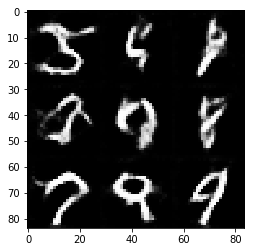

Epoch 2/2... Discriminator Loss: -1.5068... Generator Loss: -1.7577
Epoch 2/2... Discriminator Loss: -0.9736... Generator Loss: 3.6339
Epoch 2/2... Discriminator Loss: -1.1137... Generator Loss: 1.1769
Epoch 2/2... Discriminator Loss: -0.9158... Generator Loss: 0.1295
Epoch 2/2... Discriminator Loss: -1.4029... Generator Loss: 2.2713
Epoch 2/2... Discriminator Loss: -1.8075... Generator Loss: 1.7495
Epoch 2/2... Discriminator Loss: -1.8662... Generator Loss: 3.0218
Epoch 2/2... Discriminator Loss: -1.2131... Generator Loss: 2.6727
Epoch 2/2... Discriminator Loss: -1.5973... Generator Loss: 0.6473
Epoch 2/2... Discriminator Loss: -0.1412... Generator Loss: 3.9162


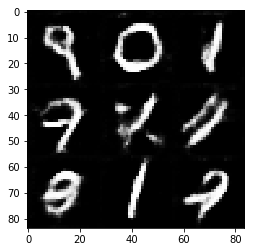

Epoch 2/2... Discriminator Loss: -1.3086... Generator Loss: 2.1963
Epoch 2/2... Discriminator Loss: -1.2265... Generator Loss: 1.8938
Epoch 2/2... Discriminator Loss: -0.8013... Generator Loss: -1.0291
Epoch 2/2... Discriminator Loss: -1.2572... Generator Loss: 2.2308
Epoch 2/2... Discriminator Loss: -1.2682... Generator Loss: 1.2782
Epoch 2/2... Discriminator Loss: -1.4084... Generator Loss: 2.5297
Epoch 2/2... Discriminator Loss: -1.5158... Generator Loss: 0.2743


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5
print_every = 10
show_every= 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: -12.2999... Generator Loss: 7.8368
Epoch 1/2... Discriminator Loss: -14.0999... Generator Loss: 17.6901
Epoch 1/2... Discriminator Loss: -9.0196... Generator Loss: 11.9471
Epoch 1/2... Discriminator Loss: -7.5317... Generator Loss: 10.6252
Epoch 1/2... Discriminator Loss: -6.1317... Generator Loss: 10.2638
Epoch 1/2... Discriminator Loss: -4.4682... Generator Loss: 6.7820
Epoch 1/2... Discriminator Loss: -4.2528... Generator Loss: 8.5613
Epoch 1/2... Discriminator Loss: -4.0239... Generator Loss: 6.6305
Epoch 1/2... Discriminator Loss: -3.5970... Generator Loss: 6.0507
Epoch 1/2... Discriminator Loss: -2.8193... Generator Loss: 7.9165


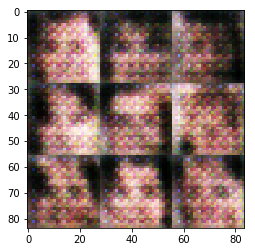

Epoch 1/2... Discriminator Loss: -2.6065... Generator Loss: 8.7994
Epoch 1/2... Discriminator Loss: -1.8166... Generator Loss: 5.5365
Epoch 1/2... Discriminator Loss: -1.6035... Generator Loss: -1.1781
Epoch 1/2... Discriminator Loss: -1.7542... Generator Loss: 0.6311
Epoch 1/2... Discriminator Loss: -1.5137... Generator Loss: 3.6694
Epoch 1/2... Discriminator Loss: -1.8241... Generator Loss: 4.8416
Epoch 1/2... Discriminator Loss: -1.3046... Generator Loss: 6.6025
Epoch 1/2... Discriminator Loss: -1.8932... Generator Loss: 1.7056
Epoch 1/2... Discriminator Loss: -1.7252... Generator Loss: -4.8806
Epoch 1/2... Discriminator Loss: -1.3647... Generator Loss: 2.9019


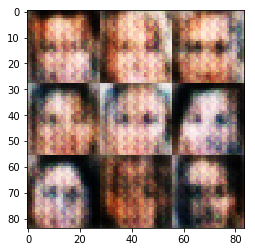

Epoch 1/2... Discriminator Loss: -1.4191... Generator Loss: -0.3782
Epoch 1/2... Discriminator Loss: -1.0409... Generator Loss: -1.6660
Epoch 1/2... Discriminator Loss: -1.0135... Generator Loss: 2.8883
Epoch 1/2... Discriminator Loss: -1.3620... Generator Loss: 4.4924
Epoch 1/2... Discriminator Loss: -1.3903... Generator Loss: -4.8361
Epoch 1/2... Discriminator Loss: -1.9442... Generator Loss: -5.6009
Epoch 1/2... Discriminator Loss: -1.4236... Generator Loss: -1.1036
Epoch 1/2... Discriminator Loss: -1.1413... Generator Loss: -6.9491
Epoch 1/2... Discriminator Loss: -1.2868... Generator Loss: 0.4654
Epoch 1/2... Discriminator Loss: -1.6414... Generator Loss: 6.0481


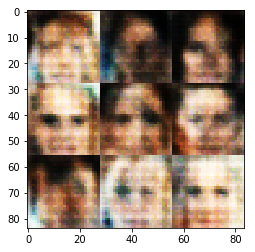

Epoch 1/2... Discriminator Loss: -1.8810... Generator Loss: -7.1033
Epoch 1/2... Discriminator Loss: -1.4331... Generator Loss: 2.3658
Epoch 1/2... Discriminator Loss: -1.5638... Generator Loss: -1.4792
Epoch 1/2... Discriminator Loss: -1.1702... Generator Loss: -1.9072
Epoch 1/2... Discriminator Loss: -1.2837... Generator Loss: -13.4762
Epoch 1/2... Discriminator Loss: -1.2775... Generator Loss: -6.3999
Epoch 1/2... Discriminator Loss: -1.3366... Generator Loss: -13.2464
Epoch 1/2... Discriminator Loss: -1.3212... Generator Loss: -11.5460
Epoch 1/2... Discriminator Loss: -1.0064... Generator Loss: -12.4494
Epoch 1/2... Discriminator Loss: -1.5800... Generator Loss: -6.3661


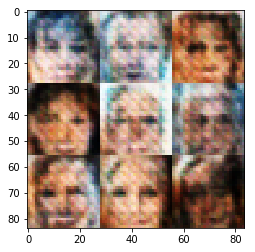

Epoch 1/2... Discriminator Loss: -0.9899... Generator Loss: -18.7700
Epoch 1/2... Discriminator Loss: -1.4875... Generator Loss: -12.3173
Epoch 1/2... Discriminator Loss: -1.3079... Generator Loss: -13.9052
Epoch 1/2... Discriminator Loss: -0.7913... Generator Loss: -11.6532
Epoch 1/2... Discriminator Loss: -1.6741... Generator Loss: -18.8241
Epoch 1/2... Discriminator Loss: -1.0476... Generator Loss: -12.4938
Epoch 1/2... Discriminator Loss: -1.5179... Generator Loss: -14.4043
Epoch 1/2... Discriminator Loss: -1.3324... Generator Loss: -20.3331
Epoch 1/2... Discriminator Loss: -1.1557... Generator Loss: -18.0350
Epoch 1/2... Discriminator Loss: -1.5933... Generator Loss: -19.6706


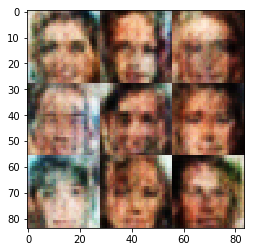

Epoch 1/2... Discriminator Loss: -1.2889... Generator Loss: -18.6914
Epoch 1/2... Discriminator Loss: -0.9686... Generator Loss: -9.8992
Epoch 1/2... Discriminator Loss: -1.4327... Generator Loss: -13.2307
Epoch 1/2... Discriminator Loss: -1.5081... Generator Loss: -15.5497
Epoch 1/2... Discriminator Loss: -1.7275... Generator Loss: -15.8902
Epoch 1/2... Discriminator Loss: -2.0101... Generator Loss: -15.4355
Epoch 1/2... Discriminator Loss: -1.3377... Generator Loss: -15.2339
Epoch 1/2... Discriminator Loss: -1.0945... Generator Loss: -17.8480
Epoch 1/2... Discriminator Loss: -1.2716... Generator Loss: -16.7352
Epoch 1/2... Discriminator Loss: -1.2453... Generator Loss: -15.7997


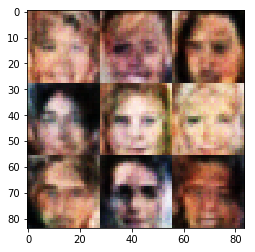

Epoch 1/2... Discriminator Loss: -1.5228... Generator Loss: -10.2544
Epoch 1/2... Discriminator Loss: -1.2328... Generator Loss: -18.6901
Epoch 1/2... Discriminator Loss: -1.3207... Generator Loss: -13.4893
Epoch 1/2... Discriminator Loss: -0.6520... Generator Loss: -17.8902
Epoch 1/2... Discriminator Loss: -1.4364... Generator Loss: -12.1960
Epoch 1/2... Discriminator Loss: -0.9271... Generator Loss: -15.2628
Epoch 1/2... Discriminator Loss: -1.0204... Generator Loss: -14.1316
Epoch 1/2... Discriminator Loss: -0.9279... Generator Loss: -12.6507
Epoch 1/2... Discriminator Loss: -1.5442... Generator Loss: -14.6150
Epoch 1/2... Discriminator Loss: -1.0160... Generator Loss: -15.2354


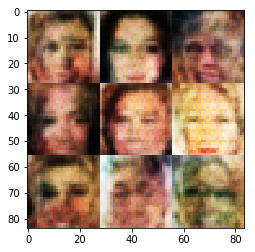

Epoch 1/2... Discriminator Loss: -1.4797... Generator Loss: -14.0341
Epoch 1/2... Discriminator Loss: -1.4679... Generator Loss: -9.0743
Epoch 1/2... Discriminator Loss: -1.2542... Generator Loss: -15.4375
Epoch 1/2... Discriminator Loss: -1.0714... Generator Loss: -6.6680
Epoch 1/2... Discriminator Loss: -0.8512... Generator Loss: -8.0689
Epoch 1/2... Discriminator Loss: -0.9499... Generator Loss: -11.9915
Epoch 1/2... Discriminator Loss: -0.9786... Generator Loss: -7.9160
Epoch 1/2... Discriminator Loss: -1.1262... Generator Loss: -12.9723
Epoch 1/2... Discriminator Loss: -1.5523... Generator Loss: -4.7834
Epoch 1/2... Discriminator Loss: -0.3955... Generator Loss: -15.4703


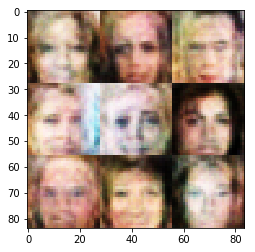

Epoch 1/2... Discriminator Loss: -0.3732... Generator Loss: -2.0495
Epoch 1/2... Discriminator Loss: -1.3587... Generator Loss: -9.7533
Epoch 1/2... Discriminator Loss: -0.6376... Generator Loss: -15.9704
Epoch 1/2... Discriminator Loss: -1.6279... Generator Loss: -11.2289
Epoch 1/2... Discriminator Loss: -0.6293... Generator Loss: -9.2755
Epoch 1/2... Discriminator Loss: -0.6463... Generator Loss: -4.2156
Epoch 1/2... Discriminator Loss: -0.9146... Generator Loss: -6.6889
Epoch 1/2... Discriminator Loss: -0.8414... Generator Loss: -11.6323
Epoch 1/2... Discriminator Loss: -1.2131... Generator Loss: -4.6165
Epoch 1/2... Discriminator Loss: -1.2959... Generator Loss: -11.8620


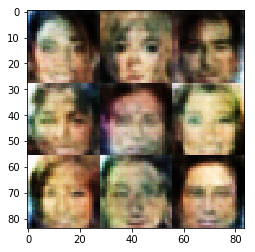

Epoch 1/2... Discriminator Loss: -1.4475... Generator Loss: -9.7349
Epoch 1/2... Discriminator Loss: -1.2036... Generator Loss: -8.0212
Epoch 1/2... Discriminator Loss: -0.8623... Generator Loss: -6.4899
Epoch 1/2... Discriminator Loss: -0.9110... Generator Loss: -8.1897
Epoch 1/2... Discriminator Loss: -0.8348... Generator Loss: 1.0621
Epoch 1/2... Discriminator Loss: -0.8787... Generator Loss: -7.7347
Epoch 1/2... Discriminator Loss: -0.5422... Generator Loss: -10.3240
Epoch 1/2... Discriminator Loss: -0.9205... Generator Loss: -11.9388
Epoch 1/2... Discriminator Loss: -1.1215... Generator Loss: -6.4209
Epoch 1/2... Discriminator Loss: -0.8015... Generator Loss: -12.4633


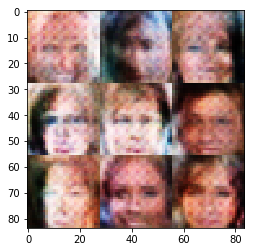

Epoch 1/2... Discriminator Loss: -0.9731... Generator Loss: -2.3481
Epoch 1/2... Discriminator Loss: -0.6325... Generator Loss: -6.8996
Epoch 1/2... Discriminator Loss: -0.8677... Generator Loss: -5.6538
Epoch 1/2... Discriminator Loss: -0.4324... Generator Loss: -2.0904
Epoch 1/2... Discriminator Loss: -1.3332... Generator Loss: -19.1031
Epoch 1/2... Discriminator Loss: -1.0204... Generator Loss: -7.0634
Epoch 1/2... Discriminator Loss: -1.2513... Generator Loss: -9.9247
Epoch 1/2... Discriminator Loss: -0.0337... Generator Loss: -10.0180
Epoch 1/2... Discriminator Loss: -0.3877... Generator Loss: -0.6238
Epoch 1/2... Discriminator Loss: -1.4566... Generator Loss: -3.6451


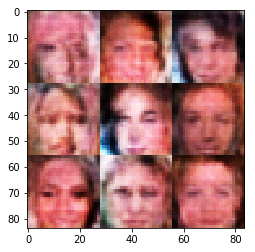

Epoch 1/2... Discriminator Loss: -1.4935... Generator Loss: -4.4554
Epoch 1/2... Discriminator Loss: -1.0738... Generator Loss: -5.1064
Epoch 1/2... Discriminator Loss: -0.9145... Generator Loss: -13.9936
Epoch 1/2... Discriminator Loss: -0.5912... Generator Loss: -12.4007
Epoch 1/2... Discriminator Loss: -1.3125... Generator Loss: -1.9601
Epoch 1/2... Discriminator Loss: -1.6032... Generator Loss: -2.2419
Epoch 1/2... Discriminator Loss: -0.5578... Generator Loss: -2.3984
Epoch 1/2... Discriminator Loss: -1.1814... Generator Loss: -2.2282
Epoch 1/2... Discriminator Loss: -0.6841... Generator Loss: -9.2313
Epoch 1/2... Discriminator Loss: -1.3563... Generator Loss: -3.5562


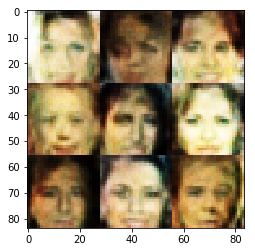

Epoch 1/2... Discriminator Loss: -0.6964... Generator Loss: 0.4335
Epoch 1/2... Discriminator Loss: -1.0829... Generator Loss: 1.3468
Epoch 1/2... Discriminator Loss: -0.8653... Generator Loss: -4.5517
Epoch 1/2... Discriminator Loss: -0.7807... Generator Loss: -6.7925
Epoch 1/2... Discriminator Loss: -1.4738... Generator Loss: -10.4523
Epoch 1/2... Discriminator Loss: -1.0815... Generator Loss: -12.4225
Epoch 1/2... Discriminator Loss: -0.7794... Generator Loss: -4.1417
Epoch 1/2... Discriminator Loss: -1.1218... Generator Loss: 2.6986
Epoch 1/2... Discriminator Loss: -1.0384... Generator Loss: -5.7379
Epoch 1/2... Discriminator Loss: -0.4539... Generator Loss: -14.3539


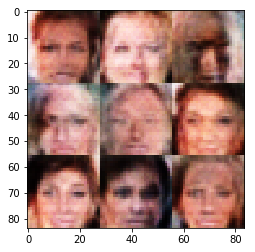

Epoch 1/2... Discriminator Loss: -1.1751... Generator Loss: -9.4589
Epoch 1/2... Discriminator Loss: -0.4919... Generator Loss: -10.2391
Epoch 1/2... Discriminator Loss: -1.1843... Generator Loss: -1.7481
Epoch 1/2... Discriminator Loss: -0.7002... Generator Loss: -8.8693
Epoch 1/2... Discriminator Loss: -1.3035... Generator Loss: 0.7326
Epoch 1/2... Discriminator Loss: -1.0779... Generator Loss: 1.1042
Epoch 1/2... Discriminator Loss: -1.1653... Generator Loss: -8.4017
Epoch 1/2... Discriminator Loss: -1.2518... Generator Loss: -2.2193
Epoch 1/2... Discriminator Loss: -1.2040... Generator Loss: -5.6504
Epoch 1/2... Discriminator Loss: -0.9953... Generator Loss: -2.0778


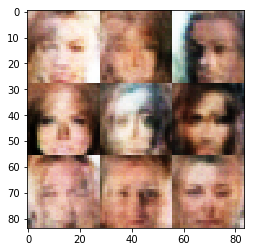

Epoch 1/2... Discriminator Loss: -0.8276... Generator Loss: -8.7946
Epoch 1/2... Discriminator Loss: -0.5415... Generator Loss: -13.5051
Epoch 1/2... Discriminator Loss: -1.0461... Generator Loss: -3.6213
Epoch 1/2... Discriminator Loss: -0.7021... Generator Loss: -2.5141
Epoch 1/2... Discriminator Loss: -1.0416... Generator Loss: -10.8975
Epoch 1/2... Discriminator Loss: -0.4880... Generator Loss: -7.2546
Epoch 1/2... Discriminator Loss: -0.9773... Generator Loss: -2.4836
Epoch 1/2... Discriminator Loss: -1.2585... Generator Loss: 5.5511
Epoch 1/2... Discriminator Loss: -0.6877... Generator Loss: -3.5656
Epoch 1/2... Discriminator Loss: -0.8251... Generator Loss: -2.0313


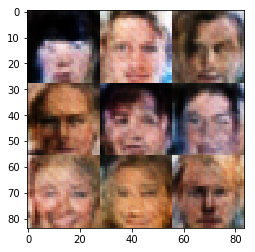

Epoch 1/2... Discriminator Loss: -1.1082... Generator Loss: -3.1830
Epoch 1/2... Discriminator Loss: -0.9531... Generator Loss: -5.2849
Epoch 1/2... Discriminator Loss: -0.9497... Generator Loss: -2.7715
Epoch 1/2... Discriminator Loss: -1.1011... Generator Loss: -0.0419
Epoch 1/2... Discriminator Loss: -1.0648... Generator Loss: 5.7990
Epoch 1/2... Discriminator Loss: -0.8003... Generator Loss: 1.5143
Epoch 1/2... Discriminator Loss: -0.7349... Generator Loss: -5.7085
Epoch 1/2... Discriminator Loss: -0.6588... Generator Loss: -12.0011
Epoch 2/2... Discriminator Loss: -1.3630... Generator Loss: -10.8787
Epoch 2/2... Discriminator Loss: -0.5971... Generator Loss: -5.4547


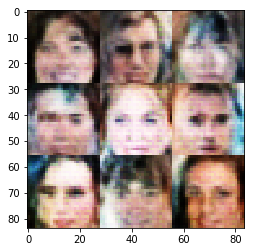

Epoch 2/2... Discriminator Loss: -0.6371... Generator Loss: -3.1300
Epoch 2/2... Discriminator Loss: -1.6635... Generator Loss: -0.6908
Epoch 2/2... Discriminator Loss: -1.2344... Generator Loss: -3.3141
Epoch 2/2... Discriminator Loss: -0.9193... Generator Loss: -4.3520
Epoch 2/2... Discriminator Loss: -0.7528... Generator Loss: -7.1019
Epoch 2/2... Discriminator Loss: -0.5583... Generator Loss: -10.9069
Epoch 2/2... Discriminator Loss: -1.0347... Generator Loss: -4.7934
Epoch 2/2... Discriminator Loss: -1.0934... Generator Loss: -9.5910
Epoch 2/2... Discriminator Loss: -1.4295... Generator Loss: -8.5043
Epoch 2/2... Discriminator Loss: -1.0333... Generator Loss: -1.7806


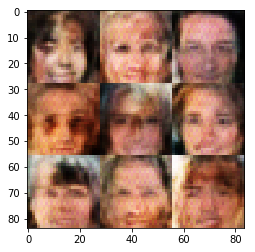

KeyboardInterrupt: 

In [22]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5
print_every = 10
show_every= 100

epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.